# Example of usage Spark OCR with Dicom Image Deidentifier

## Import Spark OCR transformers and Spark NLP annotators

## Install spark-ocr python packge
Need specify:
- license
- path to `spark-ocr-assembly-[version].jar` and `spark-nlp-jsl-[version]`
- or `secret` for Spark OCR and `nlp_secret` for Spark NLP Internal
- `aws_access_key` and `aws_secret_key`for download pretrained models

In [1]:
license = ""
secret = ""
nlp_secret = ""
aws_access_key = ""
aws_secret_key = ""

version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.11"

In [2]:
%%bash
if python -c 'import google.colab' &> /dev/null; then
    echo "Run on Google Colab!"
    echo "Install Open JDK"
    apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
    java -version
fi

In [3]:
import os
import sys

if 'google.colab' in sys.modules:
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

In [ ]:
# install from PYPI using secret
%pip install --upgrade spark-nlp-jsl==2.5.0  --extra-index-url https://pypi.johnsnowlabs.com/$nlp_secret
%pip install spark-nlp==2.5.0
%pip install spark-ocr==$version --user --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade

In [5]:
%pip install --user ../../python/dist/spark-ocr-1.4.0rc1.tar.gz

Processing /Users/nmelnik/IdeaProjects/spark-ocr/python/dist/spark-ocr-1.4.0rc1.tar.gz
  Created wheel for spark-ocr: filename=spark_ocr-1.4.0rc1-cp37-none-any.whl size=5749411 sha256=32296081895d115dbed3c145d7e35e72975568c85e9673cecbd28c945ea5a9c0
  Stored in directory: /Users/nmelnik/Library/Caches/pip/wheels/27/e6/3a/94eb4767acaee05cd2729c575d65a8d1ec636533171c941d2e
Successfully built spark-ocr
  Found existing installation: spark-ocr 1.4.0rc1
    Uninstalling spark-ocr-1.4.0rc1:
      Successfully uninstalled spark-ocr-1.4.0rc1
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Initialization of spark session

In [4]:
from sparkocr import start

if license:
    os.environ['JSL_OCR_LICENSE'] = license
    os.environ['SPARK_NLP_LICENSE'] = license

if aws_access_key:
    os.environ['AWS_ACCESS_KEY'] = aws_access_key
    os.environ['AWS_SECRET_ACCESS_KEY'] = aws_secret_key

# if secret:
spark = start(secret=secret,
              nlp_secret=nlp_secret,
              jar_path=spark_ocr_jar_path,
              nlp_version="2.5.0",
              nlp_internal=True)

spark

SparkConf Configured, Starting to listen on port: 52258
JAR PATH:/usr/local/lib/python3.7/site-packages/sparkmonitor/listener.jar


## Imports

In [5]:
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp_jsl
from sparknlp_jsl.annotator import *

import sparkocr
from sparkocr.transformers import *
from sparkocr.utils import display_image

print(f"Spark NLP version: {sparknlp.version()}")
print(f"Spark NLP internal version: {sparknlp_jsl.version()}")
print(f"Spark OCR version: {sparkocr.version()}")

Spark NLP version: 2.5.0
Spark NLP internal version: 2.5.0
Spark OCR version: 1.4.0rc1


## Define de-identification  NLP pipeline

In [16]:
def deidentification_nlp_pipeline(input_column, prefix = ""):
    document_assembler = DocumentAssembler() \
        .setInputCol(input_column) \
        .setOutputCol(prefix + "document")

    # Sentence Detector annotator, processes various sentences per line
    sentence_detector = SentenceDetector() \
        .setInputCols([prefix + "document"]) \
        .setOutputCol(prefix + "sentence")

    tokenizer = Tokenizer() \
        .setInputCols([prefix + "sentence"]) \
        .setOutputCol(prefix + "token")

    # Clinical word embeddings
    word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token"]) \
        .setOutputCol(prefix + "embeddings")
    # NER model trained on i2b2 (sampled from MIMIC) dataset
    clinical_ner = NerDLModel.pretrained("ner_deid_large", "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "embeddings"]) \
        .setOutputCol(prefix + "ner")

    custom_ner_converter = NerConverter() \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "ner"]) \
        .setOutputCol(prefix + "ner_chunk") \
        .setWhiteList(['NAME', 'AGE', 'CONTACT',
                   'LOCATION', 'PROFESSION', 'PERSON', 'DATE'])

    nlp_pipeline = Pipeline(stages=[
            document_assembler,
            sentence_detector,
            tokenizer,
            word_embeddings,
            clinical_ner,
            custom_ner_converter
        ])
    empty_data = spark.createDataFrame([[""]]).toDF(input_column)
    nlp_model = nlp_pipeline.fit(empty_data)
    return nlp_model

## Define OCR transformers and pipeline

In [17]:
# Extract images from Dicom foram
dicom_to_image = DicomToImage() \
    .setInputCol("content") \
    .setOutputCol("image_raw") \
    .setMetadataCol("metadata") \
    .setDeIdentifyMetadata(True)

# Extract text from image
ocr = ImageToText() \
    .setInputCol("image_raw") \
    .setOutputCol("text") \
    .setConfidenceThreshold(60) \
    .setLanguage("eng") \
    .setIgnoreResolution(False)

# Found sensitive data using DeIdentificationModel
deidentification_rules = DeIdentificationModel.pretrained("deidentify_rb_no_regex", "en", "clinical/models") \
    .setInputCols(["metadata_sentence", "metadata_token","metadata_ner_chunk"]) \
    .setOutputCol("deidentified_metadata_raw")

finisher = Finisher() \
    .setInputCols(["deidentified_metadata_raw"]) \
    .setOutputCols("deidentified_metadata") \
    .setOutputAsArray(False) \
    .setValueSplitSymbol("") \
    .setAnnotationSplitSymbol("")


# Found coordinates of sensetive data
position_finder = PositionFinder() \
    .setInputCols("ner_chunk") \
    .setOutputCol("coordinates") \
    .setPageMatrixCol("positions") \
    .setMatchingWindow(10) \
    .setPadding(0)

# Draw filled rectangle for hide sensetive data
drawRegions = ImageDrawRegions()  \
    .setInputCol("image_raw")  \
    .setInputRegionsCol("coordinates")  \
    .setOutputCol("image_with_regions")  \
    .setFilledRect(True)

# Store image back to Dicom document
imageToDicom = ImageToDicom() \
    .setInputCol("image_with_regions") \
    .setOutputCol("dicom") \
    .setInputMetadata("deidentified_metadata")

# OCR pipeline
pipeline = Pipeline(stages=[
    dicom_to_image,
    ocr,
    deidentification_nlp_pipeline(input_column="text"),
    deidentification_nlp_pipeline(input_column="metadata", prefix="metadata_"),
    deidentification_rules,
    position_finder,
    drawRegions,
    finisher,
    imageToDicom
])

deidentify_rb_no_regex download started this may take some time.
Approximate size to download 8.9 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_deid_large download started this may take some time.
Approximate size to download 14 MB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_deid_large download started this may take some time.
Approximate size to download 14 MB
[OK!]


## Read Dicom Object as binary file and display it

Image:
        origin: file:/Users/nmelnik/IdeaProjects/spark-ocr/workshop/jupyter/data/dicom/deidentify-medical.DCM 
        width: 800
        height: 800
        mode: 10


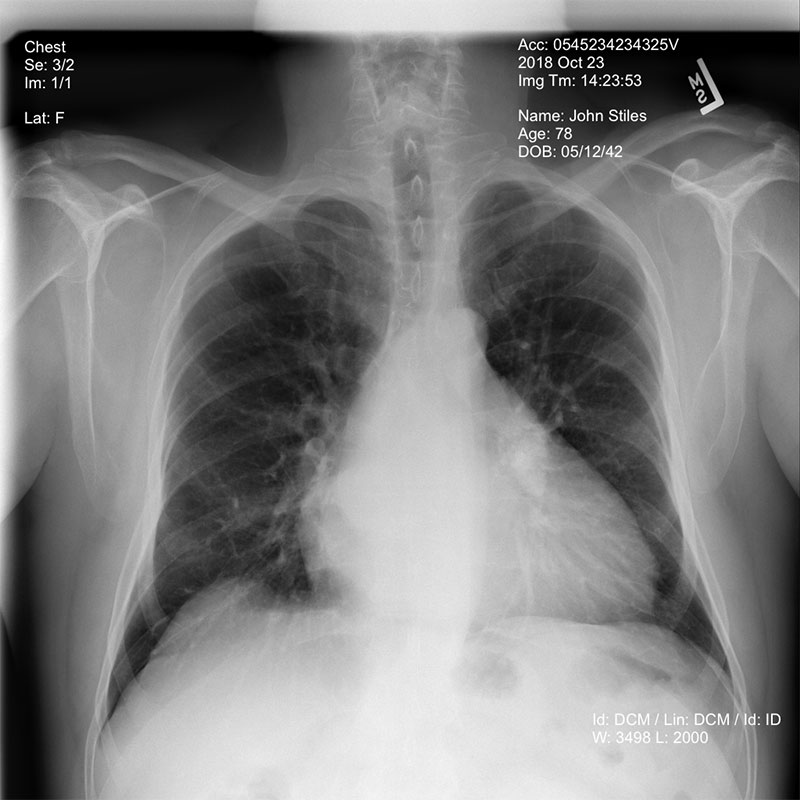


{
    "00020001": {
        "vr": "OB",
        "InlineBinary": "AAE="
    },
    "00020002": {
        "vr": "UI",
        "Value": [
            "2.25.170228217341328822848560557903560820700"
        ]
    },
    "00020003": {
        "vr": "UI",
        "Value": [
            "2.25.214240140729127103672606000638950934948"
        ]
    },
    "00020010": {
        "vr": "UI",
        "Value": [
            "1.2.840.10008.1.2.1"
        ]
    },
    "00020012": {
        "vr": "UI",
        "Value": [
            "1.2.40.0.13.1.3"
        ]
    },
    "00020013": {
        "vr": "SH",
        "Value": [
            "dcm4che-5.22.1"
        ]
    },
    "00120062": {
        "vr": "CS",
        "Value": [
            "YES"
        ]
    },
    "00120064": {
        "vr": "SQ",
        "Value": [
            {
                "00080100": {
                    "vr": "SH",
                    "Value": [
                        "113100"
                    ]
                },
          

In [8]:
dicom_path = '././data/dicom/*.dcm'
dicom_df = spark.read.format("binaryFile").load(dicom_path)

for r in dicom_to_image.setDeIdentifyMetadata(False).transform(dicom_df).collect():
    display_image(r.image_raw)
    print(r.metadata)

## Run pipeline and store result

In [18]:
de_dicom_df = pipeline.fit(dicom_df).transform(dicom_df).cache()

output_path = "././data/dicom/deidentified/"
if not os.path.exists(output_path):
    os.makedirs(output_path)

for r in de_dicom_df.select("dicom", "path").collect():
    path, name = os.path.split(r.path)
    filename_split = os.path.splitext(name)
    file_name = os.path.join(output_path, filename_split[0]+".dcm")
    print(f"Storing to {file_name}")
    with open(file_name, "wb") as file:
        file.write(r.dicom)

Storing to ././data/dicom/deidentified/deidentify-medical.DCM


## Display Deidentified Image and Deidentified metadata

Image:
        origin: file:/Users/nmelnik/IdeaProjects/spark-ocr/workshop/jupyter/data/dicom/deidentified/deidentify-medical.DCM 
        width: 800
        height: 800
        mode: 10


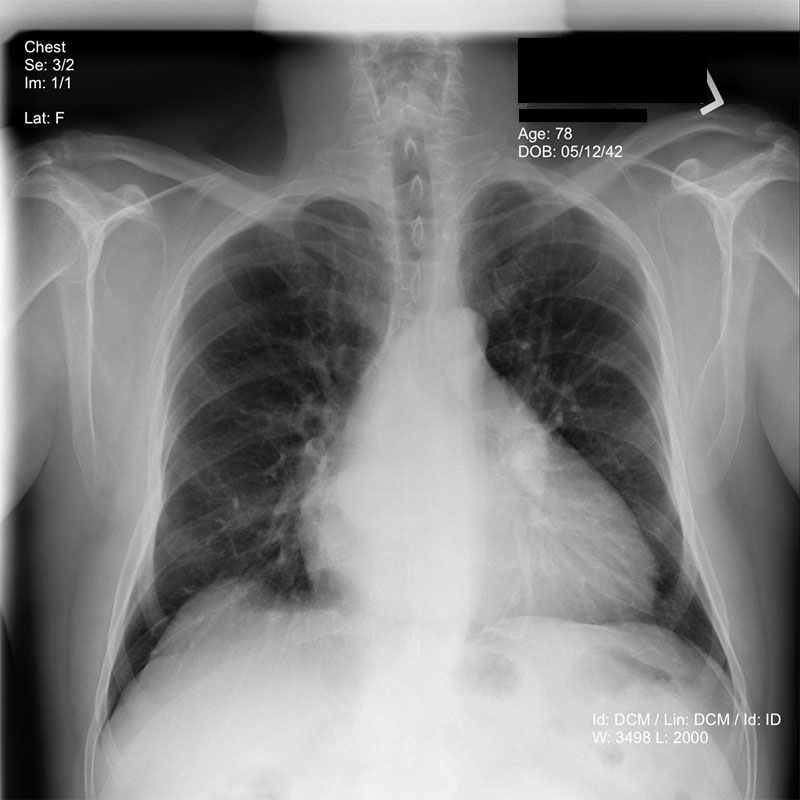


{
    "00020001": {
        "vr": "OB",
        "InlineBinary": "AAE="
    },
    "00020002": {
        "vr": "UI",
        "Value": [
            "2.25.135419584317468856514748163850291938672"
        ]
    },
    "00020003": {
        "vr": "UI",
        "Value": [
            "2.25.99080501918724777656896378454844407866"
        ]
    },
    "00020010": {
        "vr": "UI",
        "Value": [
            "1.2.840.10008.1.2.1"
        ]
    },
    "00020012": {
        "vr": "UI",
        "Value": [
            "1.2.40.0.13.1.3"
        ]
    },
    "00020013": {
        "vr": "SH",
        "Value": [
            "dcm4che-1.4.0rc1"
        ]
    },
    "00120062": {
        "vr": "CS",
        "Value": [
            "YES"
        ]
    },
    "00120064": {
        "vr": "SQ",
        "Value": [
            {
                "00080100": {
                    "vr": "SH",
                    "Value": [
                        "113100"
                    ]
                },
         

In [19]:
de_df = spark.read.format("binaryFile").load("././data/dicom/deidentified/*.dcm")
de_dicom_df = dicom_to_image.transform(de_df)
for r in de_dicom_df.select("image_raw","metadata").collect():
    display_image(r.image_raw)
    print(r.metadata)

## Remove results

%%bash
rm -r -f ././data/dicom/deidentified